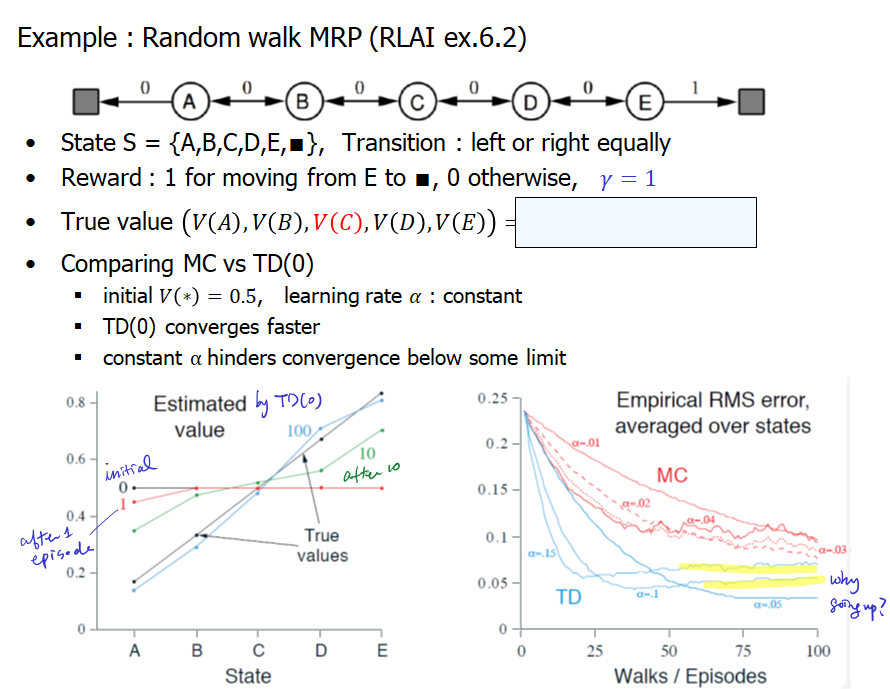

In [32]:
import numpy as np
import matplotlib.pyplot as plt

class RandomWalk1D:
    def __init__(self, n):
        self.nS = n
        self.gamma = 1
        self.P, self.R = self.getModel()
        self.s = 0
        self.trueV = self.fixedPoint()
        self.alpha = 0
        
    def getModel(self):
        n = self.nS
        P = np.zeros((n,n))
        for i in range(n-1):
            if i == 0:
                P[i,n-1] = 0.5
            else:
                P[i,i-1] = 0.5
            P[i,i+1] = 0.5
        P[n-1,n-1] = 1
        R = np.zeros((n,1))
        R[n-2] = 0.5
        return P, R
    
    def directInv(self):
        V = np.matmul(np.linalg.inv(np.eye(self.nS)-self.gamma*self.P),self.R)
        return V
    
    def initV(self, v=0.5):
        V = np.full((self.nS,1), v)
        V[self.nS-1] = 0
        return V
          
    def fixedPoint(self):
        # fixed point iteration
        V = self.initV()
        for i in range(self.nS*100):
            V = self.R + self.gamma*np.matmul(self.P, V)
        return V
    
    def step(self):
        p = np.random.rand()
        if p < 0.5:
            sp = self.s - 1
        else:
            sp = self.s + 1
        done = False
        r = 0
        if sp >= self.nS-1:
            r = 1
            done = True        
        elif sp < 0:
            sp = self.nS-1
            done = True
        self.s = sp
        return r, sp, done
    
    def runEpisode(self, s0, stepCB=None, episodeCB=None):
        self.s = s0
        done = False
        G = 0
        tau = [s0]
        while not done:
            s = self.s
            r, sp, done = self.step()
            if stepCB:
                stepCB(s, r, sp)
            tau.append(sp)
            G += r
        if episodeCB:
            episodeCB(G, tau)
        return G, tau
       
    def prediction(self, ne, stepCB=None, episodeCB=None):
        if 'RMSE' not in dir(self):
            self.RMSE = np.zeros(ne)
        self.N = np.zeros(self.nS)
        self.V = self.initV(v=0.5)
        for i in range(ne):
            self.runEpisode(round(self.nS/2), stepCB, episodeCB)
            rmse = self.getRMSE(self.V)
            self.RMSE[i] += rmse
        return self.V
    
    def getRMSE(self, V):
        d = V - self.trueV
        d = d[:-1]
        rmse = np.sqrt((d*d).mean())
        return rmse
        
    def episodeMC(self, G, tau):
        for s in reversed(tau):
            if s == self.nS - 1: 
                continue
            G *= self.gamma
            self.N[s] += 1
            if self.alpha <= 0:
                alpha = 1/self.N[s]
            else:
                alpha = self.alpha
            self.V[s] = self.V[s] + alpha*(G - self.V[s])     
    
    def stepTD(self, s, r, sp):
        self.N[s] += 1
        if self.alpha <= 0:
            alpha = 1/(self.N[s]**2)
        else:
            alpha = self.alpha
        self.V[s] = self.V[s] + alpha*(r+self.gamma*self.V[sp] - self.V[s])
    
    
    def MCprediction(self, ne):
        return self.prediction(ne, episodeCB=self.episodeMC)
    
    def TDprediction(self, ne):
        return self.prediction(ne, stepCB=self.stepTD)

    def repeatPrediction(self, ne, nrep, method='MC'):
        for i in range(nrep):
            if method == 'MC':
                self.MCprediction(ne)
            else:
                self.TDprediction(ne)
        self.RMSE /= nrep
        plt.plot(self.RMSE)
        return self.V

In [ ]:
rw = RandomWalk1D(100)
# V = rw.directInv()
V = rw.fixedPoint()
print (V)

RMSE = 0.0018091564141284667


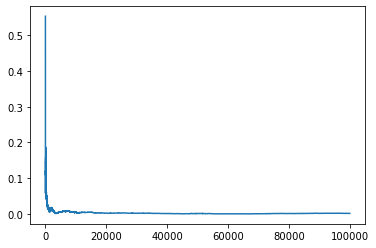

In [17]:
rw = RandomWalk1D(6)
rw.alpha = 0
V = rw.repeatPrediction(100000, 1, 'MC')
# print (V)
print (f"RMSE = {rw.getRMSE(V)}")

RMSE = 0.11459956391733321


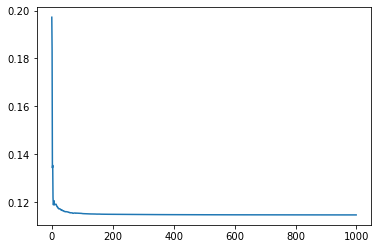

In [33]:
rw = RandomWalk1D(6)
rw.alpha = 0
V = rw.repeatPrediction(1000, 1, 'TD')
# print (V)
print (f"RMSE = {rw.getRMSE(V)}")

## RALI Ex.6.2  Random Walk 

In [34]:
#######################################################################
# Copyright (C) 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

# 0 is the left terminal state
# 6 is the right terminal state
# 1 ... 5 represents A ... E
states = np.zeros(7)
states[1:6] = 0.5
# For convenience, we assume all rewards are 0
# and the left terminal state has value 0, the right terminal state has value 1
# This trick has been used in Gambler's Problem
states[6] = 1

# set up true state values
trueValue = np.zeros(7)
trueValue[1:6] = np.arange(1, 6) / 6.0
trueValue[6] = 1

ACTION_LEFT = 0
ACTION_RIGHT = 1

In [35]:
# @states: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @states
def temporalDifference(states, alpha=0.1, batch=False):
    state = 3
    trajectory = [state]
    rewards = [0]
    while True:
        oldState = state
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        # Assume all rewards are 0
        reward = 0
        trajectory.append(state)
        # TD update
        if not batch:
            states[oldState] += alpha * (reward + states[state] - states[oldState])
        if state == 6 or state == 0:
            break
        rewards.append(reward)
    return trajectory, rewards

In [36]:
# @states: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @states
def monteCarlo(states, alpha=0.1, batch=False):
    state = 3
    trajectory = [3]
    # if end up with left terminal state, all returns are 0
    # if end up with right terminal state, all returns are 1
    returns = 0
    while True:
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        trajectory.append(state)
        if state == 6:
            returns = 1.0
            break
        elif state == 0:
            returns = 0.0
            break
    if not batch:
        for state_ in trajectory[:-1]:
            # MC update
            states[state_] += alpha * (returns - states[state_])
    return trajectory, [returns] * (len(trajectory) - 1)

In [37]:
# Figure 6.2 left
def stateValue():
    episodes = [0, 1, 10, 100]
    currentStates = np.copy(states)
    plt.figure(1)
    axisX = np.arange(0, 7)
    for i in range(0, episodes[-1] + 1):
        if i in episodes:
            plt.plot(axisX, currentStates, label=str(i) + ' episodes')
        temporalDifference(currentStates)
    plt.plot(axisX, trueValue, label='true values')
    plt.xlabel('state')
    plt.legend()

In [38]:
# Figure 6.2 right
def RMSError():
    # I'm lazy here, so do not let same alpha value appear in both arrays
    # For example, if in TD you want to use alpha = 0.2, then in MC you can use alpha = 0.201
    TDAlpha = [0.15, 0.1, 0.05]
    MCAlpha = [0.01, 0.02, 0.03, 0.04]
    episodes = 100 + 1
    runs = 100
    plt.figure(2)
    axisX = np.arange(0, episodes)
    for alpha in TDAlpha + MCAlpha:
        totalErrors = np.zeros(episodes)
        if alpha in TDAlpha:
            method = 'TD'
        else:
            method = 'MC'
        for run in range(0, runs):
            errors = []
            currentStates = np.copy(states)
            for i in range(0, episodes):
                errors.append(np.sqrt(np.sum(np.power(trueValue - currentStates, 2)) / 5.0))
                if method == 'TD':
                    temporalDifference(currentStates, alpha=alpha)
                else:
                    monteCarlo(currentStates, alpha=alpha)
            totalErrors += np.asarray(errors)
        totalErrors /= runs
        plt.plot(axisX, totalErrors, label=method + ', alpha=' + str(alpha))
    plt.xlabel('episodes')
    plt.legend()

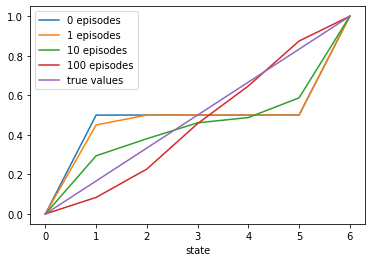

In [39]:
stateValue()   

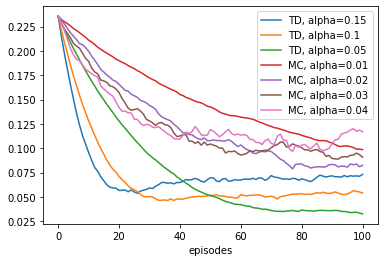

In [40]:
RMSError()

In [ ]:
# Figure 6.3
# @method: 'TD' or 'MC'
def batchUpdating(method, episodes, alpha=0.001):
    # perform 100 independent runs
    runs = 100
    totalErrors = np.zeros(episodes - 1)
    for run in range(0, runs):
        currentStates = np.copy(states)
        errors = []
        # track shown trajectories and reward/return sequences
        trajectories = []
        rewards = []
        for ep in range(1, episodes):
            print('Run:', run, 'Episode:', ep)
            if method == 'TD':
                trajectory_, rewards_ = temporalDifference(currentStates, batch=True)
            else:
                trajectory_, rewards_ = monteCarlo(currentStates, batch=True)
            trajectories.append(trajectory_)
            rewards.append(rewards_)
            while True:
                # keep feeding our algorithm with trajectories seen so far until state value function converges
                updates = np.zeros(7)
                for trajectory_, rewards_ in zip(trajectories, rewards):
                    for i in range(0, len(trajectory_) - 1):
                        if method == 'TD':
                            updates[trajectory_[i]] += rewards_[i] + currentStates[trajectory_[i + 1]] - currentStates[trajectory_[i]]
                        else:
                            updates[trajectory_[i]] += rewards_[i] - currentStates[trajectory_[i]]
                updates *= alpha
                if np.sum(np.abs(updates)) < 1e-3:
                    break
                # perform batch updating
                currentStates += updates
            # calculate rms error
            errors.append(np.sqrt(np.sum(np.power(currentStates - trueValue, 2)) / 5.0))
        totalErrors += np.asarray(errors)
    totalErrors /= episodes - 1
    return totalErrors


In [ ]:
def figure6_3():
    episodes = 100 + 1
    TDErrors = batchUpdating('TD', episodes)
    MCErrors = batchUpdating('MC', episodes)
    axisX = np.arange(1, episodes)
    plt.figure(3)
    plt.plot(axisX, TDErrors, label='TD')
    plt.plot(axisX, MCErrors, label='MC')
    plt.xlabel('episodes')
    plt.ylabel('RMS error')
    plt.legend()

In [ ]:
# Figure 6.3 may take a while to calculate
figure6_3()

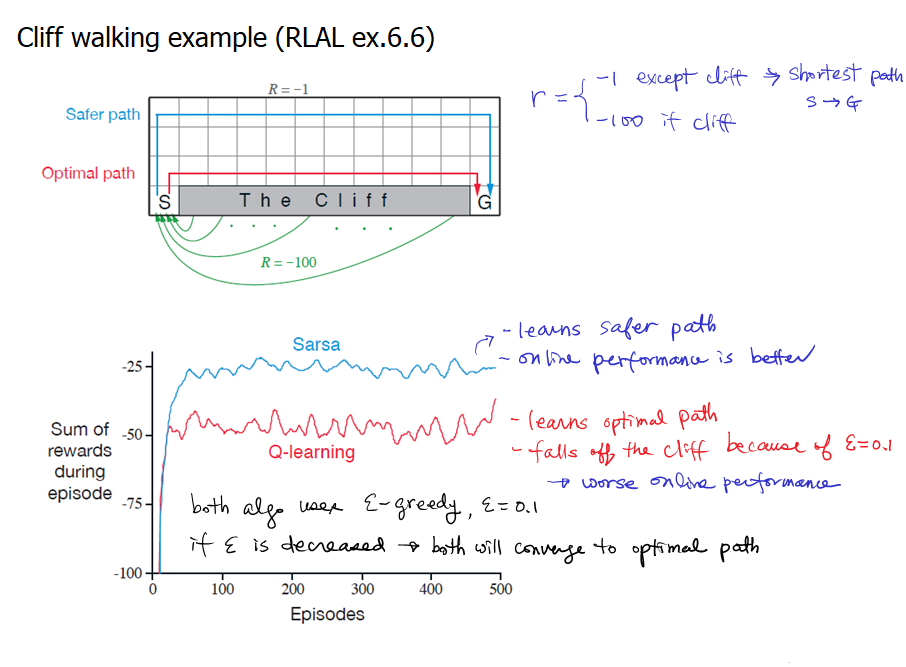

In [33]:
#######################################################################
# Copyright (C) 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import numpy as np
# from utils.utils import *
import matplotlib.pyplot as plt

# world height
WORLD_HEIGHT = 4

# world width
WORLD_WIDTH = 12

# probability for exploration
# EPSILON = 0.1

# step size
ALPHA = 0.5

# gamma for Q-Learning and Expected Sarsa
GAMMA = 1

# all possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 11]

# reward for each action in each state
actionRewards = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
actionRewards[:, :, :] = -1.0
actionRewards[2, 1:11, ACTION_DOWN] = -100.0
actionRewards[3, 0, ACTION_RIGHT] = -100.0

# set up destinations for each action in each state
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destinaion = dict()
        destinaion[ACTION_UP] = [max(i - 1, 0), j]
        destinaion[ACTION_LEFT] = [i, max(j - 1, 0)]
        destinaion[ACTION_RIGHT] = [i, min(j + 1, WORLD_WIDTH - 1)]
        if i == 2 and 1 <= j <= 10:
            destinaion[ACTION_DOWN] = startState
        else:
            destinaion[ACTION_DOWN] = [min(i + 1, WORLD_HEIGHT - 1), j]
        actionDestination[-1].append(destinaion)
actionDestination[3][0][ACTION_RIGHT] = startState


In [34]:
# choose an action based on epsilon greedy algorithm
def chooseAction(state, stateActionValues):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(actions)
    else:
        return np.argmax(stateActionValues[state[0], state[1], :])
    
def argmaxList(y):
    ymax = np.max(y)
    winner = np.argwhere(y == ymax)
    return winner.flatten().tolist()


In [35]:
# an episode with Sarsa
# @stateActionValues: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @stepSize: step size for updating
# @return: total rewards within this episode
def sarsa(stateActionValues, expected=False, stepSize=ALPHA):
    currentState = startState
    currentAction = chooseAction(currentState, stateActionValues)
    rewards = 0.0
    while currentState != goalState:
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        newAction = chooseAction(newState, stateActionValues)
        reward = actionRewards[currentState[0], currentState[1], currentAction]
        rewards += reward
        if not expected:
            valueTarget = stateActionValues[newState[0], newState[1], newAction]
        else:
            # calculate the expected value of new state
            valueTarget = 0.0
#             bestActions = argmax(stateActionValues[newState[0], newState[1], :], unique=False)
            bestActions = argmaxList(stateActionValues[newState[0], newState[1], :])
            for action in actions:
                if action in bestActions:
                    valueTarget += ((1.0 - EPSILON) / len(bestActions) + EPSILON / len(actions)) * stateActionValues[newState[0], newState[1], action]
                else:
                    valueTarget += EPSILON / len(actions) * stateActionValues[newState[0], newState[1], action]
            valueTarget *= GAMMA
        # Sarsa update
        stateActionValues[currentState[0], currentState[1], currentAction] += stepSize * (reward +
            valueTarget - stateActionValues[currentState[0], currentState[1], currentAction])
        currentState = newState
        currentAction = newAction
    return rewards


In [36]:
# an episode with Q-Learning
# @stateActionValues: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @stepSize: step size for updating
# @return: total rewards within this episode
def qLearning(stateActionValues, stepSize=ALPHA):
    currentState = startState
    rewards = 0.0
    while currentState != goalState:
        currentAction = chooseAction(currentState, stateActionValues)
        reward = actionRewards[currentState[0], currentState[1], currentAction]
        rewards += reward
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        # Q-Learning update
        stateActionValues[currentState[0], currentState[1], currentAction] += stepSize * (
            reward + GAMMA * np.max(stateActionValues[newState[0], newState[1], :]) -
            stateActionValues[currentState[0], currentState[1], currentAction])
        currentState = newState
    return rewards


In [37]:
# print optimal policy
def printOptimalPolicy(stateActionValues):
    optimalPolicy = []
    for i in range(0, WORLD_HEIGHT):
        optimalPolicy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == goalState:
                optimalPolicy[-1].append('G')
                continue
            bestAction = np.argmax(stateActionValues[i, j, :])
            if bestAction == ACTION_UP:
                optimalPolicy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimalPolicy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimalPolicy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimalPolicy[-1].append('R')
    for row in optimalPolicy:
        print(row)

Sarsa Optimal Policy:
['R', 'R', 'R', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'U', 'L', 'R', 'U', 'L', 'R', 'U', 'U', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-Learning Optimal Policy:
['L', 'R', 'R', 'R', 'U', 'U', 'R', 'R', 'R', 'D', 'D', 'D']
['R', 'D', 'R', 'R', 'R', 'D', 'R', 'R', 'R', 'D', 'D', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


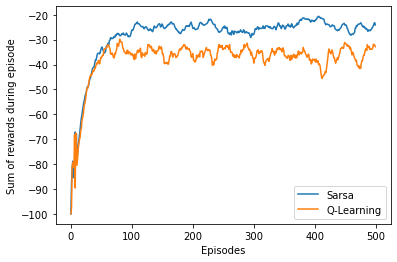

In [46]:
# figure 6.5
# Use 20 independent runs instead of a single run to draw the figure
# Actually with a single run I failed to present a smooth curve
# However the optimal policy converges well with a single run
# Sarsa converges to the safe path, while Q-Learning converges to the optimal path
def figure6_5():
    global EPSILON
    # averaging the reward sums from 10 successive episodes
    averageRange = 10

    # episodes of each run
    nEpisodes = 500

    # perform 20 independent runs
    runs = 20

    rewardsSarsa = np.zeros(nEpisodes)
    rewardsQLearning = np.zeros(nEpisodes)
    for run in range(0, runs):
        stateActionValuesSarsa = np.copy(stateActionValues)
        stateActionValuesQLearning = np.copy(stateActionValues)
        for i in range(0, nEpisodes):
#             EPSILON = 1/(i+2)
            # cut off the value by -100 to draw the figure more elegantly
            rewardsSarsa[i] += max(sarsa(stateActionValuesSarsa), -100)
            rewardsQLearning[i] += max(qLearning(stateActionValuesQLearning), -100)

    # averaging over independt runs
    rewardsSarsa /= runs
    rewardsQLearning /= runs

    # averaging over successive episodes
    smoothedRewardsSarsa = np.copy(rewardsSarsa)
    smoothedRewardsQLearning = np.copy(rewardsQLearning)
    for i in range(averageRange, nEpisodes):
        smoothedRewardsSarsa[i] = np.mean(rewardsSarsa[i - averageRange: i + 1])
        smoothedRewardsQLearning[i] = np.mean(rewardsQLearning[i - averageRange: i + 1])

    # display optimal policy
    print('Sarsa Optimal Policy:')
    printOptimalPolicy(stateActionValuesSarsa)
    print('Q-Learning Optimal Policy:')
    printOptimalPolicy(stateActionValuesQLearning)

    # draw reward curves
    plt.figure(1)
    plt.plot(smoothedRewardsSarsa, label='Sarsa')
    plt.plot(smoothedRewardsQLearning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.legend()
    
EPSILON = 0.1
figure6_5()

In [ ]:
# Due to limited capacity of calculation of my machine, I can't complete this experiment
# with 100,000 episodes and 50,000 runs to get the fully averaged performance
# However even I only play for 1,000 episodes and 10 runs, the curves looks still good.
def figure6_7():
    stepSizes = np.arange(0.1, 1.1, 0.1)
    nEpisodes = 1000
    runs = 10

    ASY_SARSA = 0
    ASY_EXPECTED_SARSA = 1
    ASY_QLEARNING = 2
    INT_SARSA = 3
    INT_EXPECTED_SARSA = 4
    INT_QLEARNING = 5
    methods = range(0, 6)

    performace = np.zeros((6, len(stepSizes)))
    for run in range(0, runs):
        for ind, stepSize in zip(range(0, len(stepSizes)), stepSizes):
            stateActionValuesSarsa = np.copy(stateActionValues)
            stateActionValuesExpectedSarsa = np.copy(stateActionValues)
            stateActionValuesQLearning = np.copy(stateActionValues)
            for ep in range(0, nEpisodes):
                print('run:', run, 'step size:', stepSize, 'episode:', ep)
                sarsaReward = sarsa(stateActionValuesSarsa, expected=False, stepSize=stepSize)
                expectedSarsaReward = sarsa(stateActionValuesExpectedSarsa, expected=True, stepSize=stepSize)
                qLearningReward = qLearning(stateActionValuesQLearning, stepSize=stepSize)
                performace[ASY_SARSA, ind] += sarsaReward
                performace[ASY_EXPECTED_SARSA, ind] += expectedSarsaReward
                performace[ASY_QLEARNING, ind] += qLearningReward

                if ep < 100:
                    performace[INT_SARSA, ind] += sarsaReward
                    performace[INT_EXPECTED_SARSA, ind] += expectedSarsaReward
                    performace[INT_QLEARNING, ind] += qLearningReward

    performace[:3, :] /= nEpisodes * runs
    performace[3:, :] /= runs * 100
    labels = ['Asymptotic Sarsa', 'Asymptotic Expected Sarsa', 'Asymptotic Q-Learning',
              'Interim Sarsa', 'Interim Expected Sarsa', 'Interim Q-Learning']
    plt.figure(2)
    for method, label in zip(methods, labels):
        plt.plot(stepSizes, performace[method, :], label=label)
    plt.xlabel('alpha')
    plt.ylabel('reward per episode')
    plt.legend()

    
# Drawing figure 6.7 may take a while
figure6_7()

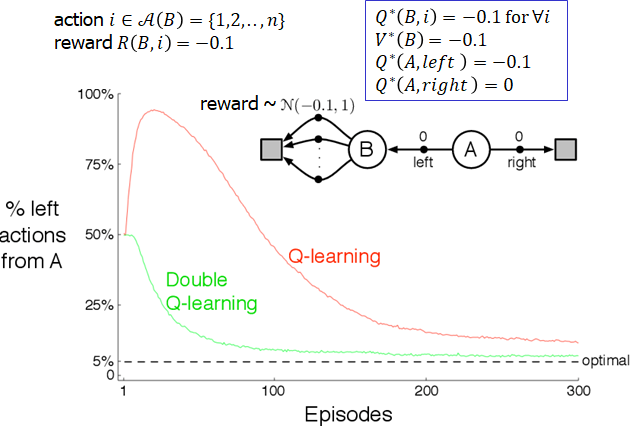

In [15]:

from __future__ import print_function
import numpy as np
# from utils.utils import *
import matplotlib.pyplot as plt

# state A
STATE_A = 0

# state B
STATE_B = 1

# use one terminal state
STATE_TERMINAL = 2

# starts from state A
STATE_START = STATE_A

# possible actions in A
ACTION_A_RIGHT = 0
ACTION_A_LEFT = 1

# possible actions in B, maybe 10 actions
actionsOfB = range(0, 10)

# all possible actions
stateActions = [[ACTION_A_RIGHT, ACTION_A_LEFT], actionsOfB]

# state action pair values, if a state is a terminal state, then the value is always 0
stateActionValues = [np.zeros(2), np.zeros(len(actionsOfB)), np.zeros(1)]

# set up destination for each state and each action
actionDestination = [[STATE_TERMINAL, STATE_B], [STATE_TERMINAL] * len(actionsOfB)]

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.1

# discount for max value
GAMMA = 1.0



In [16]:
# choose an action based on epsilon greedy algorithm
def chooseAction(state, stateActionValues):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(stateActions[state])
    else:
        return np.argmax(stateActionValues[state])

# take @action in @state, return the reward
def takeAction(state, action):
    if state == STATE_A:
        return 0
    return np.random.normal(-0.1, 1)

In [17]:
# if there are two state action pair value array, use double Q-Learning
# otherwise use normal Q-Learning
def qLearning(stateActionValues, stateActionValues2=None):
    currentState = STATE_START
    # track the # of action left in state A
    leftCount = 0
    while currentState != STATE_TERMINAL:
        if stateActionValues2 is None:
            currentAction = chooseAction(currentState, stateActionValues)
        else:
            # derive a action form Q1 and Q2
            currentAction = chooseAction(currentState, [item1 + item2 for item1, item2 in zip(stateActionValues, stateActionValues2)])
        if currentState == STATE_A and currentAction == ACTION_A_LEFT:
            leftCount += 1
        reward = takeAction(currentState, currentAction)
        newState = actionDestination[currentState][currentAction]
        if stateActionValues2 is None:
            currentStateActionValues = stateActionValues
            targetValue = np.max(currentStateActionValues[newState])
        else:
            if np.random.binomial(1, 0.5) == 1:
                currentStateActionValues = stateActionValues
                anotherStateActionValues = stateActionValues2
            else:
                currentStateActionValues = stateActionValues2
                anotherStateActionValues = stateActionValues
#             original double Q
            bestAction = np.argmax(currentStateActionValues[newState])
            targetValue = anotherStateActionValues[newState][bestAction]
#             what if we swap the role of two Q's : not much different
#             bestAction = np.argmax(anotherStateActionValues[newState])
#             targetValue = currentStateActionValues[newState][bestAction]

        # Q-Learning update
        currentStateActionValues[currentState][currentAction] += ALPHA * (
            reward + GAMMA * targetValue - currentStateActionValues[currentState][currentAction])
        currentState = newState
    return leftCount


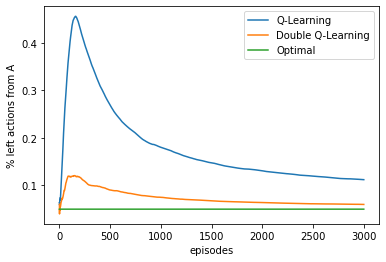

In [18]:
# Figure 6.8, 1,000 runs may be enough, # of actions in state B will also affect the curves
def figure6_8():
    # each independent run has 300 episodes
    episodes = 3000
    leftCountsQ = np.zeros(episodes)
    leftCountsDoubleQ = np.zeros(episodes)
    runs = 100
    for run in range(0, runs):
#         print('run:', run)
        stateActionValuesQ = [np.copy(item) for item in stateActionValues]
        stateActionValuesDoubleQ1 = [np.copy(item) for item in stateActionValues]
        stateActionValuesDoubleQ2 = [np.copy(item) for item in stateActionValues]
        leftCountsQ_ = [0]
        leftCountsDoubleQ_ = [0]
        for ep in range(0, episodes):
            global EPSILON
#             EPSILON = 1/(ep+2)
            leftCountsQ_.append(leftCountsQ_[-1] + qLearning(stateActionValuesQ))
            leftCountsDoubleQ_.append(leftCountsDoubleQ_[-1] + qLearning(stateActionValuesDoubleQ1, stateActionValuesDoubleQ2))
        del leftCountsQ_[0]
        del leftCountsDoubleQ_[0]
        leftCountsQ += np.asarray(leftCountsQ_, dtype='float') / np.arange(1, episodes + 1)
        leftCountsDoubleQ += np.asarray(leftCountsDoubleQ_, dtype='float') / np.arange(1, episodes + 1)
    leftCountsQ /= runs
    leftCountsDoubleQ /= runs
    plt.figure()
    plt.plot(leftCountsQ, label='Q-Learning')
    plt.plot(leftCountsDoubleQ, label='Double Q-Learning')
    plt.plot(np.ones(episodes) * 0.05, label='Optimal')
    plt.xlabel('episodes')
    plt.ylabel('% left actions from A')
    plt.legend()

# it may take a while
figure6_8()

### Example 6.5 Windy Gridworld

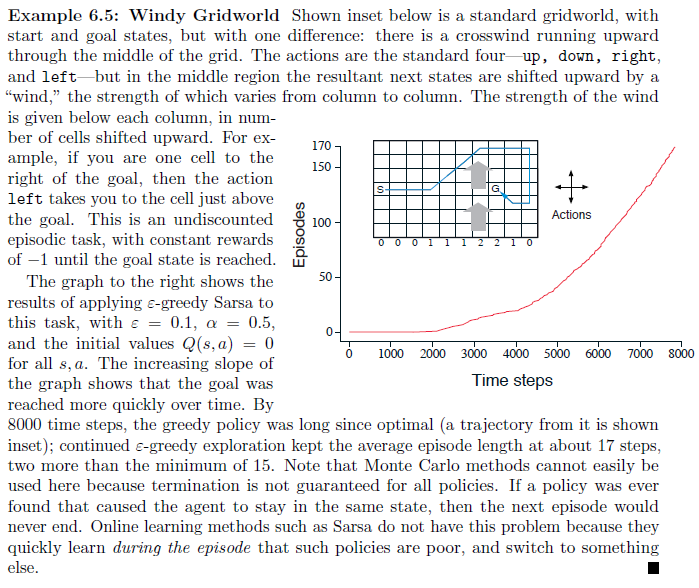

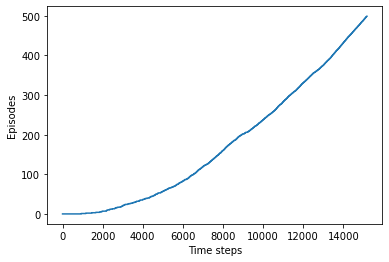

['L', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'D', 'U', 'U', 'D']
['U', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'L', 'R', 'R', 'G', 'R', 'D']
['U', 'R', 'D', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['R', 'D', 'R', 'R', 'D', 'U', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'U', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [6]:
#######################################################################
# Copyright (C) 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import numpy as np
# from utils.utils import *
import matplotlib.pyplot as plt

# world height
WORLD_HEIGHT = 7

# world width
WORLD_WIDTH = 10

# wind strength for each column
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probability for exploration
EPSILON = 0.1

# Sarsa step size
ALPHA = 0.5

# reward for each step
REWARD = -1.0

# state action pair value
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 7]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# set up destinations for each action in each state
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destination = dict()
        destination[ACTION_UP] = [max(i - 1 - WIND[j], 0), j]
        destination[ACTION_DOWN] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
        destination[ACTION_LEFT] = [max(i - WIND[j], 0), max(j - 1, 0)]
        destination[ACTION_RIGHT] = [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
        actionDestination[-1].append(destination)

# play for an episode
def oneEpisode():
    # track the total time steps in this episode
    time = 0

    # initialize state
    currentState = startState

    # choose an action based on epsilon-greedy algorithm
    if np.random.binomial(1, EPSILON) == 1:
        currentAction = np.random.choice(actions)
    else:
        currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])

    # keep going until get to the goal state
    while currentState != goalState:
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        if np.random.binomial(1, EPSILON) == 1:
            newAction = np.random.choice(actions)
        else:
            newAction = np.argmax(stateActionValues[newState[0], newState[1], :])
        # Sarsa update
        stateActionValues[currentState[0], currentState[1], currentAction] += \
            ALPHA * (REWARD + stateActionValues[newState[0], newState[1], newAction] -
            stateActionValues[currentState[0], currentState[1], currentAction])
        currentState = newState
        currentAction = newAction
        time += 1
    return time

# play for 500 episodes to make sure to get a more converged policy
# episodeLimit = 200

# figure 6.4
episodeLimit = 500
ep = 0
episodes = []
while ep < episodeLimit:
    time = oneEpisode()
    episodes.extend([ep] * time)
    ep += 1

plt.figure()
plt.plot(episodes)
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

# display the optimal policy
optimalPolicy = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicy.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicy[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicy[-1].append('R')
for row in optimalPolicy:
    print(row)
print([str(w) for w in WIND])

### Windy Gridworld with n-step SARSA

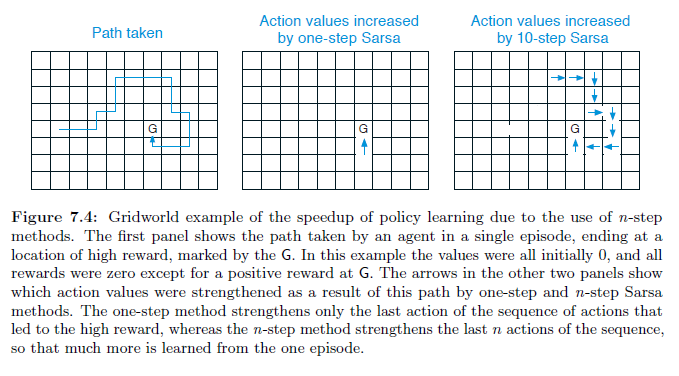

### Random walk (n=19) using n-step TD

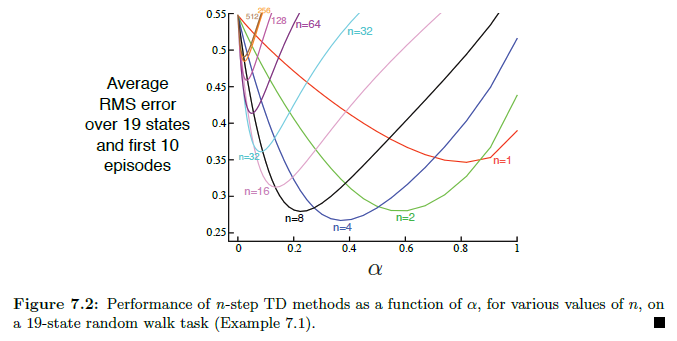

In [ ]:
#######################################################################
# Copyright (C) 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

# all states
N_STATES = 19

# discount
GAMMA = 1

# initial state values
stateValues = np.zeros(N_STATES + 2)

# all states but terminal states
states = np.arange(1, N_STATES + 1)

# start from the middle state
START_STATE = 10

# two terminal states
# an action leading to the left terminal state has reward -1
# an action leading to the right terminal state has reward 1
END_STATES = [0, N_STATES + 1]

# true state value from bellman equation
realStateValues = np.arange(-20, 22, 2) / 20.0
realStateValues[0] = realStateValues[-1] = 0

# n-steps TD method
# @stateValues: values for each state, will be updated
# @n: # of steps
# @alpha: # step size
def temporalDifference(stateValues, n, alpha):
    # initial starting state
    currentState = START_STATE

    # arrays to store states and rewards for an episode
    # space isn't a major consideration, so I didn't use the mod trick
    states = [currentState]
    rewards = [0]

    # track the time
    time = 0

    # the length of this episode
    T = float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # choose an action randomly
            if np.random.binomial(1, 0.5) == 1:
                newState = currentState + 1
            else:
                newState = currentState - 1
            if newState == 0:
                reward = -1
            elif newState == 20:
                reward = 1
            else:
                reward = 0

            # store new state and new reward
            states.append(newState)
            rewards.append(reward)

            if newState in END_STATES:
                T = time

        # get the time of the state to update
        updateTime = time - n
        if updateTime >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(updateTime + 1, min(T, updateTime + n) + 1):
                returns += pow(GAMMA, t - updateTime - 1) * rewards[t]
            # add state value to the return
            if updateTime + n <= T:
                returns += pow(GAMMA, n) * stateValues[states[(updateTime + n)]]
            stateToUpdate = states[updateTime]
            # update the state value
            if not stateToUpdate in END_STATES:
                stateValues[stateToUpdate] += alpha * (returns - stateValues[stateToUpdate])
        if updateTime == T - 1:
            break
        currentState = newState

# Figure 7.2, it will take quite a while
def figure7_2():
    # truncate value for better display
    truncateValue = 0.55

    # all possible steps
    steps = np.power(2, np.arange(0, 10))

    # all possible alphas
    alphas = np.arange(0, 1.1, 0.1)

    # each run has 10 episodes
    episodes = 10

    # perform 100 independent runs
    runs = 100

    # track the errors for each (step, alpha) combination
    errors = np.zeros((len(steps), len(alphas)))
    for run in range(0, runs):
        for stepInd, step in zip(range(len(steps)), steps):
            for alphaInd, alpha in zip(range(len(alphas)), alphas):
                print('run:', run, 'step:', step, 'alpha:', alpha)
                currentStateValues = np.copy(stateValues)
                for ep in range(0, episodes):
                    temporalDifference(currentStateValues, step, alpha)
                    # calculate the RMS error
                    errors[stepInd, alphaInd] += np.sqrt(np.sum(np.power(currentStateValues - realStateValues, 2)) / N_STATES)
    # take average
    errors /= episodes * runs
    # truncate the error
    errors[errors > truncateValue] = truncateValue
    plt.figure()
    for i in range(0, len(steps)):
        plt.plot(alphas, errors[i, :], label='n = ' + str(steps[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.legend()

figure7_2()
plt.show()

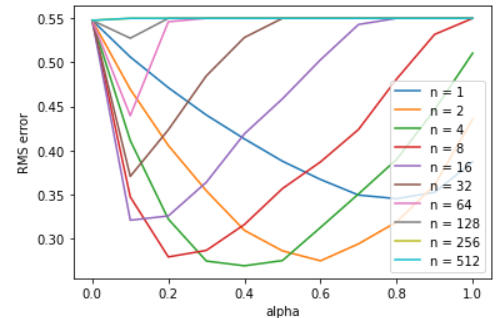